# Wild Blueberry Yield Prediction 🍇🍇🍇

`Imports`

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',None)

## `EDA`
1. Basic Lookup
2. Outlier Detection
3. Multicollinearity Check
4. Target Variable Distribution
5. Bucketisation of Categorical Variables (if any)
6. Column-wise Analysis / Distribution

Loading Data:::

In [2]:
rootdf = pd.read_csv("../dataset/WildBlueberryPollinationSimulationData.csv")

In [3]:
print(rootdf.shape)
rootdf.sample(5)

(777, 18)


Row#  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
123   123       12.5      0.25     0.25     0.25   0.75              77.4   
567   567       25.0      0.50     0.25     0.63   0.50              69.7   
610   610       25.0      0.50     0.25     0.75   0.50              77.4   
367   367       12.5      0.25     0.38     0.38   0.50              77.4   
69     69       12.5      0.25     0.25     0.25   0.38              94.6   

     MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
123              46.8                  64.7              55.8   
567              42.1                  58.2              50.2   
610              46.8                  64.7              55.8   
367              46.8                  64.7              55.8   
69               57.2                  79.0              68.2   

     MinOfLowerTRange  AverageOfLowerTRange  RainingDays  AverageRainingDays  \
123              27.0                  45.8         16.0                0.26   
567              24.3                  41.2         24.0                0.39   
610              27.0                  45.8          1.0                0.10   
367              27.0                  45.8         24.0                0.39   
69               33.0                  55.9         16.0                0.26   

     fruitset  fruitmass      seeds        yield  
123  0.607396   0.501359  42.074573  7829.514000  
567  0.429581   0.391524  31.101615  4945.794431  
610  0.510669   0.452680  36.386359  6279.338501  
367  0.598814   0.498586  41.730667  7510.790568  
69   0.512803   0.452144  36.311593  5746.777027

In [3]:
# Delete Row# column as it is Just an index
rootdf.drop(['Row#'],axis=1,inplace=True)
print(rootdf.shape)
rootdf.sample(5)

(777, 17)


clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
774       20.0     0.537    0.117    0.409  0.058              86.0   
504       25.0     0.500    0.250    0.380  0.750              69.7   
739       25.0     0.500    0.380    0.500  0.750              69.7   
98        12.5     0.250    0.250    0.250  0.500              69.7   
131       12.5     0.250    0.250    0.380  0.250              86.0   

     MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
774              52.0                  71.9              62.0   
504              42.1                  58.2              50.2   
739              42.1                  58.2              50.2   
98               42.1                  58.2              50.2   
131              52.0                  71.9              62.0   

     MinOfLowerTRange  AverageOfLowerTRange  RainingDays  AverageRainingDays  \
774              30.0                  50.8         24.0                0.39   
504              24.3                  41.2         34.0                0.56   
739              24.3                  41.2         16.0                0.26   
98               24.3                  41.2         34.0                0.56   
131              30.0                  50.8         16.0                0.26   

     fruitset  fruitmass      seeds        yield  
774  0.404617   0.401670  30.748240  4203.027624  
504  0.402839   0.379343  29.833158  4460.914573  
739  0.498716   0.431072  35.184412  6034.642135  
98   0.443297   0.399724  31.909316  4868.211449  
131  0.526615   0.458255  37.031744  6026.063649

In [10]:
numerical_feature = [feature for feature in rootdf.columns if rootdf[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(rootdf[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in rootdf.columns if feature not in numerical_feature]

print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 17
Discrete feature Count 13
Continuous feature Count 4
Categorical feature Count 0


In [6]:
rootdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             777 non-null    float64
 1   honeybee              777 non-null    float64
 2   bumbles               777 non-null    float64
 3   andrena               777 non-null    float64
 4   osmia                 777 non-null    float64
 5   MaxOfUpperTRange      777 non-null    float64
 6   MinOfUpperTRange      777 non-null    float64
 7   AverageOfUpperTRange  777 non-null    float64
 8   MaxOfLowerTRange      777 non-null    float64
 9   MinOfLowerTRange      777 non-null    float64
 10  AverageOfLowerTRange  777 non-null    float64
 11  RainingDays           777 non-null    float64
 12  AverageRainingDays    777 non-null    float64
 13  fruitset              777 non-null    float64
 14  fruitmass             777 non-null    float64
 15  seeds                 7

In [8]:
rootdf.describe().T

count         mean          std          min  \
clonesize             777.0    18.767696     6.999063    10.000000   
honeybee              777.0     0.417133     0.978904     0.000000   
bumbles               777.0     0.282389     0.066343     0.000000   
andrena               777.0     0.468817     0.161052     0.000000   
osmia                 777.0     0.562062     0.169119     0.000000   
MaxOfUpperTRange      777.0    82.277091     9.193745    69.700000   
MinOfUpperTRange      777.0    49.700515     5.595769    39.000000   
AverageOfUpperTRange  777.0    68.723037     7.676984    58.200000   
MaxOfLowerTRange      777.0    59.309395     6.647760    50.200000   
MinOfLowerTRange      777.0    28.690219     3.209547    24.300000   
AverageOfLowerTRange  777.0    48.613127     5.417072    41.200000   
RainingDays           777.0    18.309292    12.124226     1.000000   
AverageRainingDays    777.0     0.320000     0.171279     0.060000   
fruitset              777.0     0.502121     0.079445     0.192732   
fruitmass             777.0     0.445983     0.040333     0.311921   
seeds                 777.0    36.122432     4.377889    22.079199   
yield                 777.0  6012.849165  1356.955318  1637.704022   

                              25%          50%          75%          max  
clonesize               12.500000    12.500000    25.000000    40.000000  
honeybee                 0.250000     0.250000     0.500000    18.430000  
bumbles                  0.250000     0.250000     0.380000     0.585000  
andrena                  0.380000     0.500000     0.630000     0.750000  
osmia                    0.500000     0.630000     0.750000     0.750000  
MaxOfUpperTRange        77.400000    86.000000    89.000000    94.600000  
MinOfUpperTRange        46.800000    52.000000    52.000000    57.200000  
AverageOfUpperTRange    64.700000    71.900000    71.900000    79.000000  
MaxOfLowerTRange        55.800000    62.000000    66.000000    68.200000  
MinOfLowerTRange        27.000000    30.000000    30.000000    33.000000  
AverageOfLowerTRange    45.800000    50.800000    50.800000    55.900000  
RainingDays              3.770000    16.000000    24.000000    34.000000  
AverageRainingDays       0.100000     0.260000     0.390000     0.560000  
fruitset                 0.454725     0.508297     0.561297     0.652144  
fruitmass                0.416281     0.445587     0.476149     0.535660  
seeds                   33.116091    36.166044    39.239668    46.585105  
yield                 5124.854901  6107.382466  7022.189731  8969.401842

<div class="alert alert-block alert-info">
Description of data collection:	A total of 77,700 simulations were conducted to achieve both an extensive and intensive sampling effort and this resulted in a dataset consisting of 777 records, each of which is an average of 100 simulation runs. </div>

![Alt text](image.png)

<a href="https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea">How to: Multi-Collinearity</a>

<Axes: >

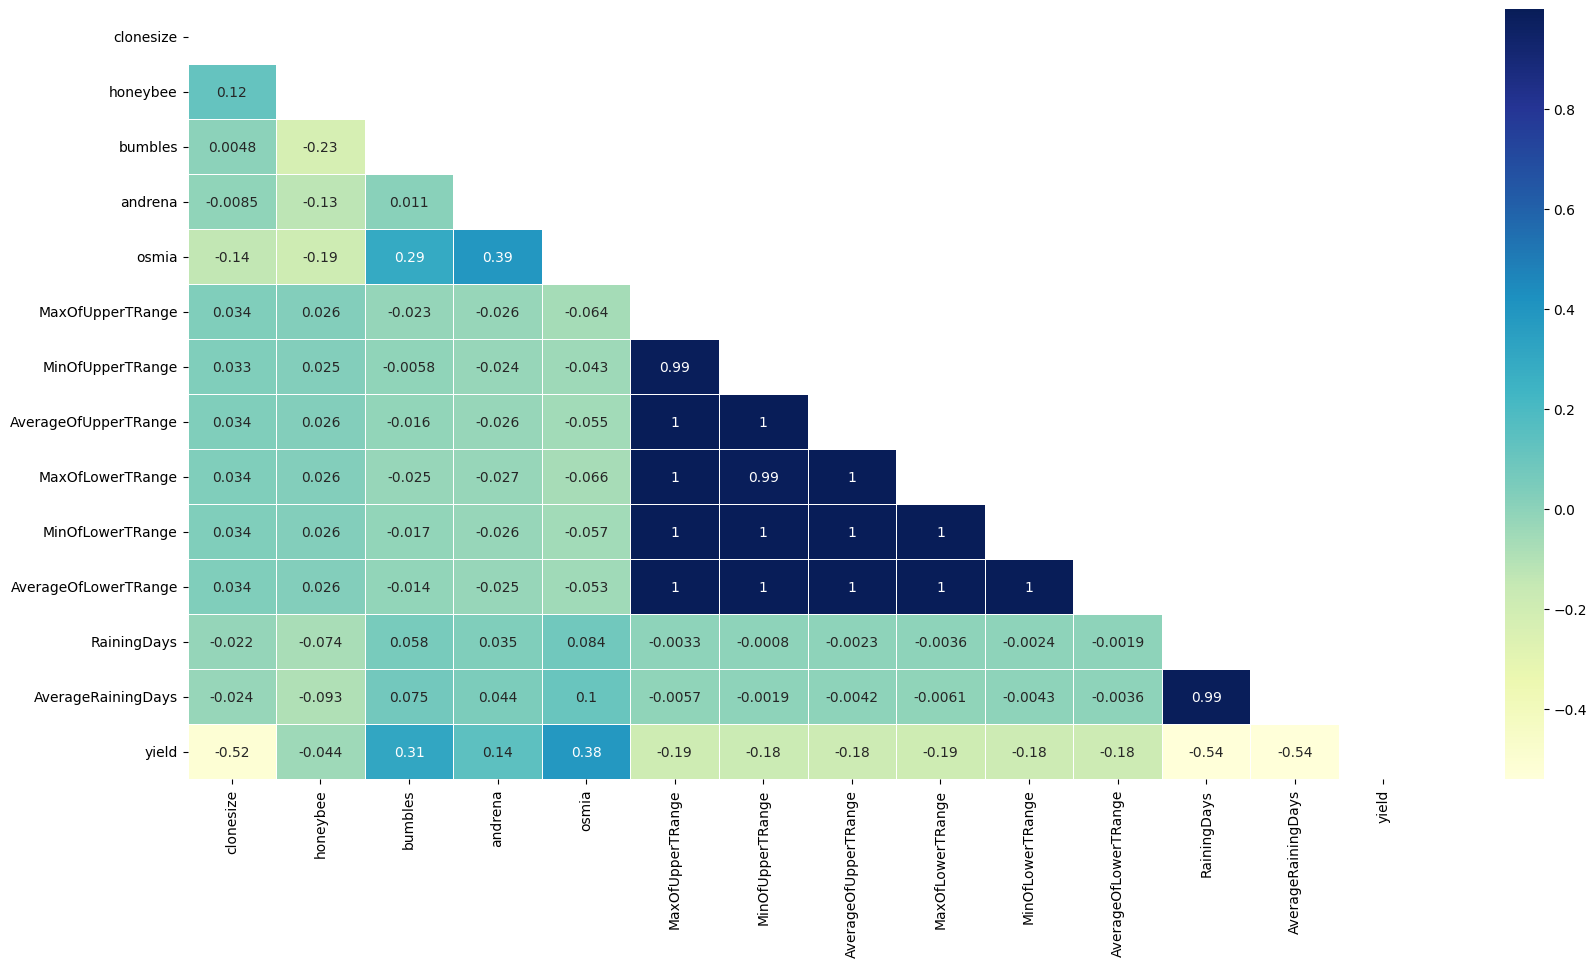

In [68]:
plt.figure(figsize=(20,10))
corr=rootdf.corr()
matrix = np.triu(rootdf.corr())
sns.heatmap(corr,xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True,
            linewidths=.5, mask=matrix, cmap="YlGnBu")

In [5]:
def vif_scores(df,target,e=False):
    vif = pd.DataFrame()
    vif["Features"] = df.drop(target,axis=1).columns
    vif["VIF Score"] = [variance_inflation_factor(df.drop(target,axis=1).values, i) for i in range(df.drop(target,axis=1).shape[1])]
    # Format the VIF scores without "e" notation
    if e==True:
        vif["VIF Score"] = ['%.2f' % elem for elem in vif["VIF Score"]]
    return(vif.sort_values(by='VIF Score',ascending=False))

In [6]:
vif_scores(rootdf,'yield',True)

Features    VIF Score
5       MaxOfUpperTRange          inf
6       MinOfUpperTRange          inf
8       MaxOfLowerTRange          inf
9       MinOfLowerTRange          inf
7   AverageOfUpperTRange  94389548.91
13              fruitset        80.87
14             fruitmass       764.37
12    AverageRainingDays        71.32
11           RainingDays        64.10
15                 seeds       566.71
10  AverageOfLowerTRange  48271143.78
0              clonesize         3.80
1               honeybee         3.48
2                bumbles         2.23
4                  osmia         1.89
3                andrena         1.28

In [7]:
# VIF Scores
vif = vif_scores(rootdf,'yield')
selected_features = vif[vif["VIF Score"] < 10]["Features"] # Selecting features which have VIF less than 10
print("Top Features as per vif: ",selected_features.values)

Top Features as per vif:  ['clonesize' 'honeybee' 'bumbles' 'osmia' 'andrena']


<div class="alert alert-block alert-info">
<b>Observation:</b> MaxOfUpper/LowerTRange are highly corelated features</div>

<code style="background:yellow;color:black">INFO about the Corelated Features (Domain Study)</code> <br><br>
![Alt text](image-1.png)

In [12]:
for i in rootdf.drop('yield',axis=1).columns:
    
    IQR=rootdf[i].quantile(0.75)-rootdf[i].quantile(0.25)
    lower_bridge=rootdf[i].quantile(0.25)-(IQR*1.5)
    upper_bridge=rootdf[i].quantile(0.75)+(IQR*1.5)
    
    outs = []
    
    for j in rootdf[i]:
        if j<lower_bridge:
            outs.append(j)
    
    for k in rootdf[i]:
        if k>upper_bridge:
            outs.append(k)

    print(f'The percentage of outliers in {i}:',(len(outs)/len(rootdf)*100),'%')

The percentage of outliers in clonesize: 0.0 %
The percentage of outliers in honeybee: 0.5148005148005148 %
The percentage of outliers in bumbles: 0.9009009009009009 %
The percentage of outliers in andrena: 0.5148005148005148 %
The percentage of outliers in osmia: 2.187902187902188 %
The percentage of outliers in MaxOfUpperTRange: 0.0 %
The percentage of outliers in MinOfUpperTRange: 0.0 %
The percentage of outliers in AverageOfUpperTRange: 0.0 %
The percentage of outliers in MaxOfLowerTRange: 0.0 %
The percentage of outliers in MinOfLowerTRange: 0.0 %
The percentage of outliers in AverageOfLowerTRange: 0.0 %
The percentage of outliers in RainingDays: 0.0 %
The percentage of outliers in AverageRainingDays: 0.0 %
The percentage of outliers in fruitset: 1.1583011583011582 %
The percentage of outliers in fruitmass: 0.2574002574002574 %
The percentage of outliers in seeds: 0.2574002574002574 %


<div class="alert alert-block alert-info"> No significant Outliers! </div>

<a href="https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d">How to: Feature Distribution</a>

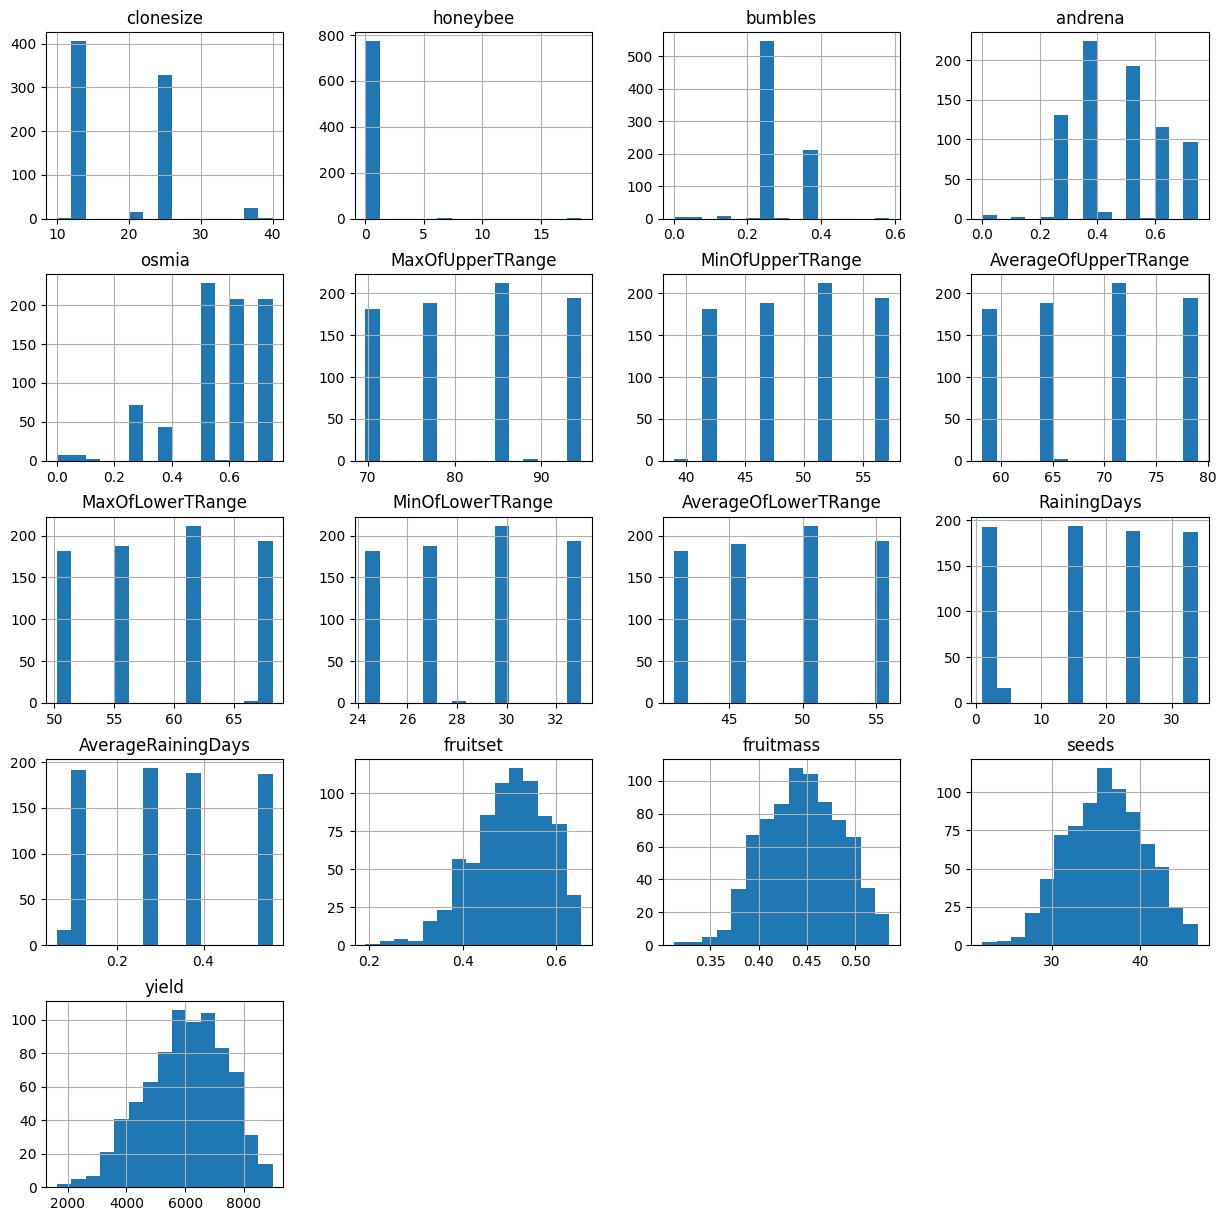

In [37]:
rootdf.hist(bins=15, figsize=(15, 15));

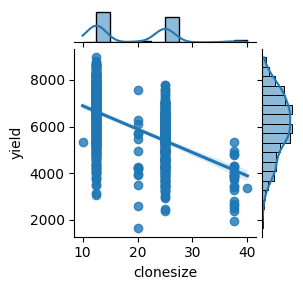

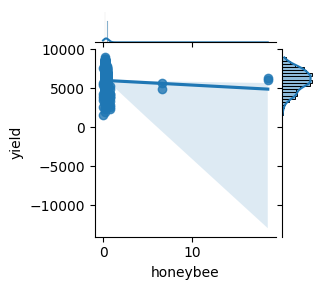

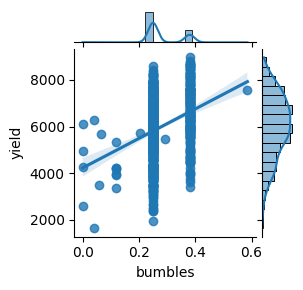

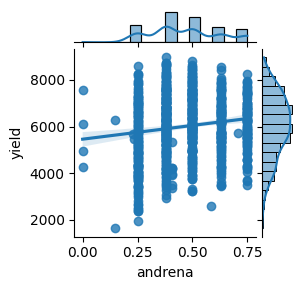

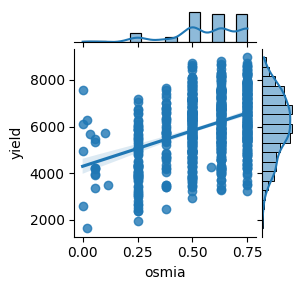

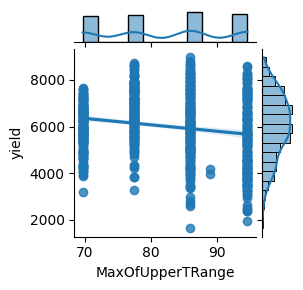

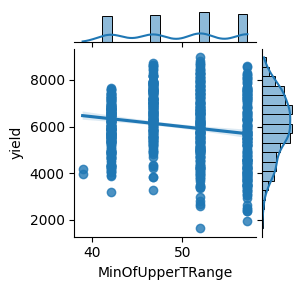

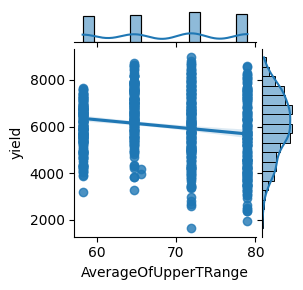

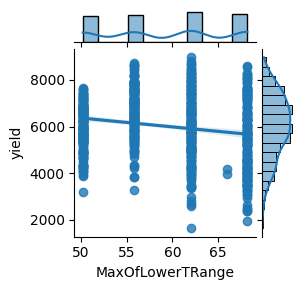

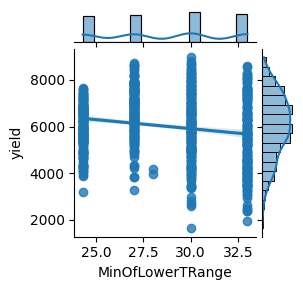

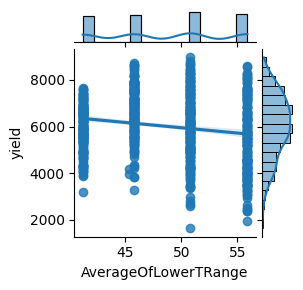

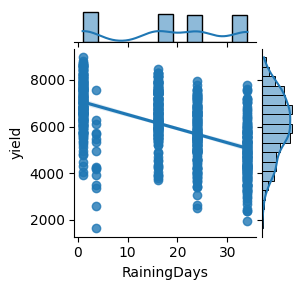

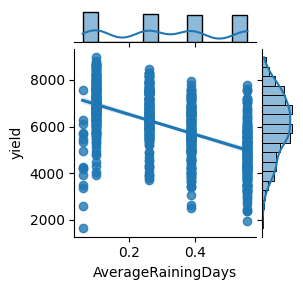

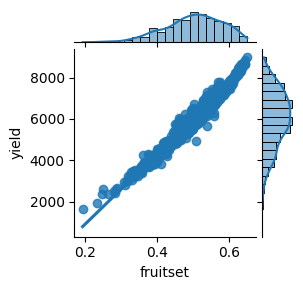

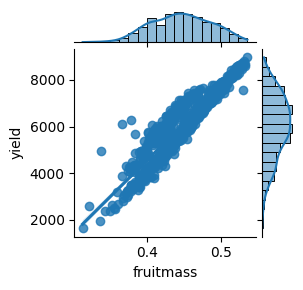

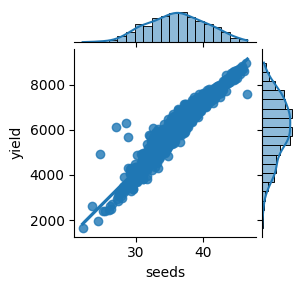

In [52]:
for i in rootdf.drop('yield',axis=1).columns:
    sns.jointplot(x=i, y='yield', data=rootdf, kind='reg', height=3);

Note: above can be mapped using FacetGrid Above can be better...

<div class="alert alert-block alert-info">
<b>Observation:</b> 
<p>AverageUpper/LowerTRange | AverageRainingDays | Clonesize are Inversely Proportional to Yield</p>
<p>seeds | fruitmass | fruitset | bumbles | andrea | osmia are Directly Proportional to Yield</p>
<p> Honeybee is slightly inversely proportional to yeild </p>
</div>

In [53]:
rootdf.isnull().sum()

clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

<Axes: xlabel='yield', ylabel='Count'>

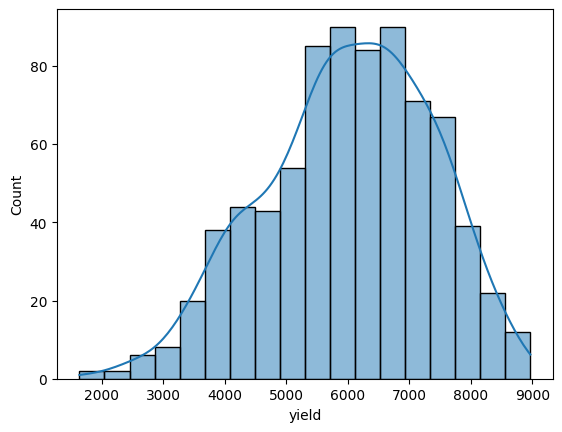

In [56]:
sns.histplot(rootdf['yield'],kde=True)

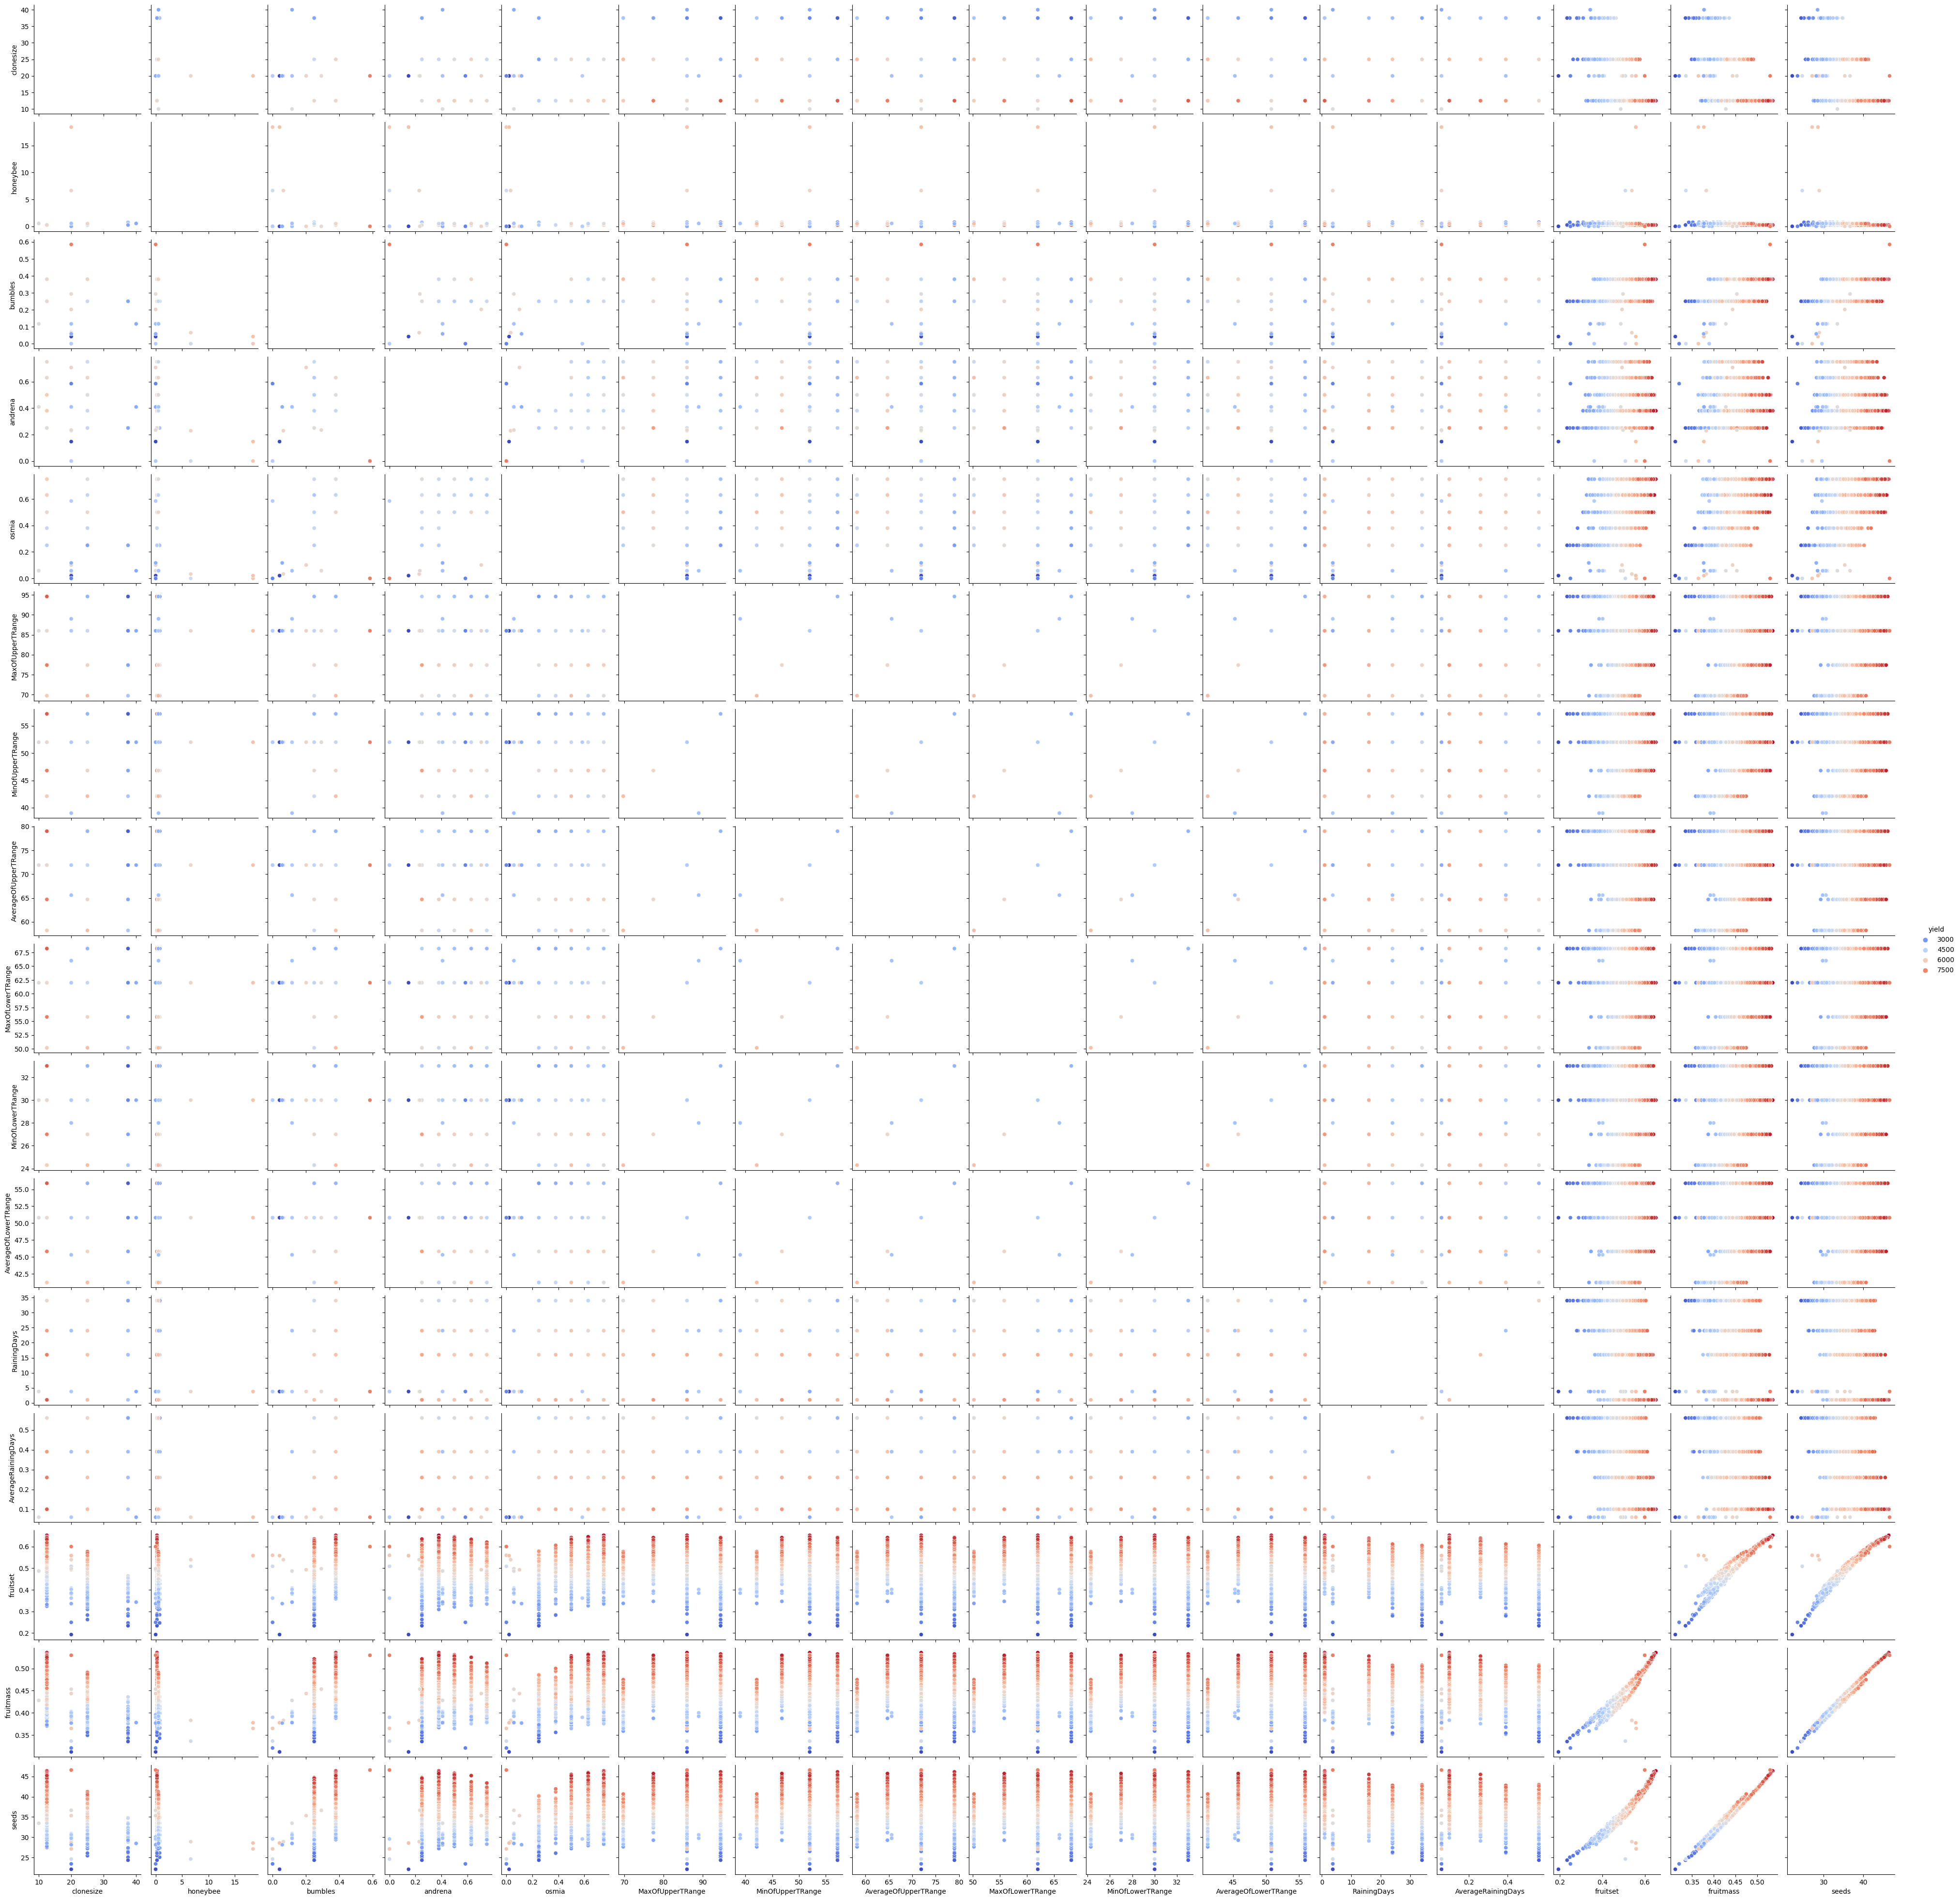

In [11]:
sns.pairplot(rootdf,hue='yield',palette='coolwarm')

<div class="alert alert-block alert-danger">
- From the dataset paper and description, <b>Seeds / Fruitmass / Fruitset</b> are simulation predicted values. (Can be seen from jointplots!) <br>
- We can't use these features for prediction. <br>
- We can have a combination of remaining 13 features to predict the yield. <br>
- There are no missing values in the dataset. <br>
- Many histograms show `discrete` distribution of values. <br>
</div>

## `Data Preprocessing`
1. Missing Value Treatment
2. Outlier Treatment
3. Intuative Feature Dropping (if any)
4. Imbalanced Data Handling (Dependant variable)
5. Splitting into Train and Test

\# Dropping <b>Seeds / Fruitmass / Fruitset</b>

In [4]:
rootdf.shape

(777, 17)

In [5]:
# Will drop Seeds / frutimass / fruitset columns
X = rootdf.copy().drop(['seeds','fruitmass','fruitset'],axis=1)
print(X.shape)
X.sample(5)

(777, 14)


clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
375       12.5      0.25     0.38     0.38   0.63              86.0   
181       12.5      0.25     0.25     0.38   0.63              94.6   
6         37.5      0.75     0.25     0.25   0.25              94.6   
367       12.5      0.25     0.38     0.38   0.50              77.4   
16        37.5      0.25     0.25     0.25   0.25              86.0   

     MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
375              52.0                  71.9              62.0   
181              57.2                  79.0              68.2   
6                57.2                  79.0              68.2   
367              46.8                  64.7              55.8   
16               52.0                  71.9              62.0   

     MinOfLowerTRange  AverageOfLowerTRange  RainingDays  AverageRainingDays  \
375              30.0                  50.8         24.0                0.39   
181              33.0                  55.9         16.0                0.26   
6                33.0                  55.9         24.0                0.39   
367              27.0                  45.8         24.0                0.39   
16               30.0                  50.8         34.0                0.56   

           yield  
375  7270.318318  
181  7107.609758  
6    2625.269164  
367  7510.790568  
16   2688.028831

In [6]:
X = X.drop('yield',axis=1)
y = rootdf['yield']
# Train, Test Split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=88)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((621, 13), (156, 13), (621,), (156,))

## `Baseline Model`
1. Multiple - Model Training
2. Model Evaluation
3. Model Selection

In [6]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test._get_numeric_data())
        mse = mean_squared_error(y_test, y_pred)
        scores['xgb_rmse'] = np.sqrt(mse) # RMSE : Root Mean Squared Error
        models.append(xgb)

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestRegressor()
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        scores['rf_rmse'] = np.sqrt(mse) # RMSE : Root Mean Squared Error
        models.append(rf)

    if 'lr' in kwargs.keys() and kwargs['lr']:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        scores['lr_rmse'] = np.sqrt(mse) # RMSE : Root Mean Squared Error
        models.append(lr)
        
    if 'dt' in kwargs.keys() and kwargs['dt']:
        dt = DecisionTreeRegressor()
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        scores['dt_rmse'] = np.sqrt(mse) # RMSE : Root Mean Squared Error
        models.append(dt)
        
    return scores, models

In [7]:
scores, models = modelling(X_train, y_train, X_test, y_test, xgb=True, rf=True, lr=True, dt=True)
print(scores)

{'xgb_rmse': 268.5271457441949, 'rf_rmse': 314.33033152984666, 'lr_rmse': 460.41508662299265, 'dt_rmse': 395.18983856958835}


In [8]:
currxgb = models[0]
currxgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<div class="alert alert-block alert-info"> 
Going ahead with <b>XGBoost Regressor</b> <br>
</div>

## `Feature Engineering`
1. Feature Extraction (if any) contains : 
    - Feature Generation
    - Feature Transformation
    - Feature Scaling
    - Feature **Encoding**
2. Feature Selection (if any) contains :
    - Feature Importance
    - Feature Elimination
    - Feature Selection


<Axes: xlabel='importance', ylabel='feature'>

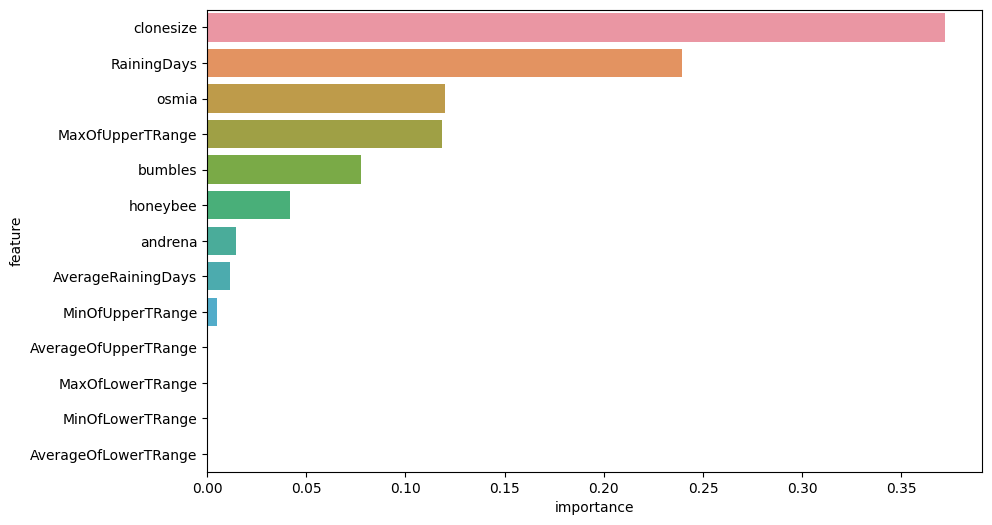

In [19]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': currxgb.feature_importances_})
feature_importance.sort_values('importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)

<div class="alert alert-block alert-success"> 
We can experiment with 2 Datasets : <br>
- <b>Dataset 1</b> : Dropping AverageOfUpperTRange & AverageOfLowerTRange & MaxOfLowerTRange & MinOFLowerTRange <br>
- <b>Dataset 2</b> : All 13 Features <b>{Default}</b> <br>
</div>

## `Re-Processing` Final-Features Selected Data
yet to be experimented with : <br>

## `Hyperparameter Tuning`

<a ref="https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#:~:text=What%20parameters%20should%20I%20tune,tree%2C%20and%20the%20subsample%20ratio."> Mastering XGBoost Parameter Tuning: A Complete Guide with Python Codes</div>

In [10]:
def modelfit(modelx, xtrain, ytrain, useTrainCV=True, cv_folds=15, early_stopping=50 ):
    '''
    The number of boosting rounds where early stopping occurred 
    is considered the >"optimal"< number of estimators! 
    '''
    
    # For finding the optimal number of estimators...
    if useTrainCV:
        xgb_param = modelx.get_xgb_params()
        xgtrain = xgb.DMatrix(xtrain, label=ytrain)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=modelx.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='rmse', early_stopping_rounds=early_stopping)
        
        # cv result stores the error at each round
        # cvresult.shape[0] contains the number of estimators (boosting rounds)
        
        modelx.set_params(n_estimators=cvresult.shape[0])
        print('Optimal number of estimators: (n_estimators)::: ', cvresult.shape[0]) 
        
    # Fit the algorithm on the data
    modelx.fit(xtrain, ytrain, eval_metric='rmse')
    
    # Predict training set:
    y_train_pred = modelx.predict(xtrain)
    
    # Print model report:
    print("\nModel Report:::")
    print('RMSE on train data:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
    
    return modelx

#### Step 1: Finding the `number of estimators` for a high learning rate

In [12]:
xgb_1 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    cosample_bytree=0.8,
    objective='reg:squarederror',
    seed=27,
)

modelfit(xgb_1, X_train, y_train)

parameters = xgb_1.get_params()

Optimal number of estimators: (n_estimators):::  146

Model Report:::
RMSE on train data: 107.67614100196892


#### Step 2: Tune `max_depth` and `min_child_weight`
starting with the learning rate

In [17]:
param_test_lr = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}
gsearch_lr = GridSearchCV(estimator = XGBRegressor(n_estimators=43), 
 param_grid = param_test_lr, scoring='neg_root_mean_squared_error',n_jobs=1, cv=15, verbose=3)
gsearch_lr.fit(X_train,y_train)
gsearch_lr.best_params_, gsearch_lr.best_score_

Fitting 15 folds for each of 5 candidates, totalling 75 fits
[CV 1/15] END .............learning_rate=0.1;, score=-193.089 total time=   0.0s
[CV 2/15] END .............learning_rate=0.1;, score=-188.719 total time=   0.0s
[CV 3/15] END .............learning_rate=0.1;, score=-236.406 total time=   0.0s
[CV 4/15] END .............learning_rate=0.1;, score=-207.157 total time=   0.0s
[CV 5/15] END .............learning_rate=0.1;, score=-198.814 total time=   0.0s
[CV 6/15] END .............learning_rate=0.1;, score=-782.197 total time=   0.0s
[CV 7/15] END .............learning_rate=0.1;, score=-265.100 total time=   0.0s
[CV 8/15] END .............learning_rate=0.1;, score=-257.434 total time=   0.0s
[CV 9/15] END .............learning_rate=0.1;, score=-212.692 total time=   0.0s
[CV 10/15] END ............learning_rate=0.1;, score=-407.580 total time=   0.0s
[CV 11/15] END ............learning_rate=0.1;, score=-204.200 total time=   0.0s
[CV 12/15] END ............learning_rate=0.1;, s

({'learning_rate': 0.2}, -265.646490601782)

In [18]:
param_test_depth_child = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(5,11,1)
}
# Updating the learning rate as per the above result
gsearch2 = GridSearchCV(estimator = XGBRegressor(n_estimators=43, learning_rate = 0.2), 
 param_grid = param_test_depth_child, scoring='neg_root_mean_squared_error',n_jobs=1, cv=15, verbose=3)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

Fitting 15 folds for each of 42 candidates, totalling 630 fits
[CV 1/15] END max_depth=3, min_child_weight=5;, score=-252.520 total time=   0.0s
[CV 2/15] END max_depth=3, min_child_weight=5;, score=-193.886 total time=   0.0s
[CV 3/15] END max_depth=3, min_child_weight=5;, score=-285.178 total time=   0.0s
[CV 4/15] END max_depth=3, min_child_weight=5;, score=-212.928 total time=   0.0s
[CV 5/15] END max_depth=3, min_child_weight=5;, score=-200.642 total time=   0.0s
[CV 6/15] END max_depth=3, min_child_weight=5;, score=-605.898 total time=   0.0s
[CV 7/15] END max_depth=3, min_child_weight=5;, score=-290.766 total time=   0.0s
[CV 8/15] END max_depth=3, min_child_weight=5;, score=-263.358 total time=   0.0s
[CV 9/15] END max_depth=3, min_child_weight=5;, score=-314.829 total time=   0.0s
[CV 10/15] END max_depth=3, min_child_weight=5;, score=-460.761 total time=   0.0s
[CV 11/15] END max_depth=3, min_child_weight=5;, score=-212.240 total time=   0.0s
[CV 12/15] END max_depth=3, min_c

({'max_depth': 7, 'min_child_weight': 5}, -266.18508199647556)

#### Step 3: Tune `gamma` 

In [19]:
param_test_gamma = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(n_estimators=43, max_depth=7,min_child_weight=5, learning_rate = 0.2), 
 param_grid = param_test_gamma, scoring='neg_root_mean_squared_error',n_jobs=1, cv=15, verbose=3)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

Fitting 15 folds for each of 5 candidates, totalling 75 fits
[CV 1/15] END .....................gamma=0.0;, score=-177.306 total time=   0.0s
[CV 2/15] END .....................gamma=0.0;, score=-189.100 total time=   0.0s
[CV 3/15] END .....................gamma=0.0;, score=-270.157 total time=   0.1s
[CV 4/15] END .....................gamma=0.0;, score=-194.820 total time=   0.1s
[CV 5/15] END .....................gamma=0.0;, score=-188.409 total time=   0.0s
[CV 6/15] END .....................gamma=0.0;, score=-585.329 total time=   0.0s
[CV 7/15] END .....................gamma=0.0;, score=-255.578 total time=   0.1s
[CV 8/15] END .....................gamma=0.0;, score=-222.558 total time=   0.3s
[CV 9/15] END .....................gamma=0.0;, score=-224.471 total time=   0.1s
[CV 10/15] END ....................gamma=0.0;, score=-439.324 total time=   0.1s
[CV 11/15] END ....................gamma=0.0;, score=-194.474 total time=   0.0s
[CV 12/15] END ....................gamma=0.0;, s

({'gamma': 0.0}, -266.18508199647556)

Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

In [21]:
xgb_2 = XGBRegressor(n_estimators=1000, max_depth=7,min_child_weight=5, learning_rate = 0.2, gamma=0.0)
 #                                ^^^^
modelfit(xgb_2, X_train, y_train) 

Optimal number of estimators: (n_estimators):::  45

Model Report:::
RMSE on train data: 140.5443336386113


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=45, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Step 4: Tune `subsample` and `colsample_bytree`

In [22]:
param_test_sample = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(n_estimators=45, max_depth=7,min_child_weight=5, learning_rate = 0.2, gamma = 0.0), 
 param_grid = param_test_sample, scoring='neg_root_mean_squared_error',n_jobs=1, cv=15, verbose=3)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

Fitting 15 folds for each of 25 candidates, totalling 375 fits
[CV 1/15] END colsample_bytree=0.6, subsample=0.6;, score=-185.581 total time=   0.0s
[CV 2/15] END colsample_bytree=0.6, subsample=0.6;, score=-176.541 total time=   0.0s
[CV 3/15] END colsample_bytree=0.6, subsample=0.6;, score=-247.839 total time=   0.0s
[CV 4/15] END colsample_bytree=0.6, subsample=0.6;, score=-201.481 total time=   0.0s
[CV 5/15] END colsample_bytree=0.6, subsample=0.6;, score=-207.636 total time=   0.0s
[CV 6/15] END colsample_bytree=0.6, subsample=0.6;, score=-630.355 total time=   0.0s
[CV 7/15] END colsample_bytree=0.6, subsample=0.6;, score=-227.914 total time=   0.0s
[CV 8/15] END colsample_bytree=0.6, subsample=0.6;, score=-187.974 total time=   0.0s
[CV 9/15] END colsample_bytree=0.6, subsample=0.6;, score=-259.544 total time=   0.0s
[CV 10/15] END colsample_bytree=0.6, subsample=0.6;, score=-475.157 total time=   0.0s
[CV 11/15] END colsample_bytree=0.6, subsample=0.6;, score=-176.956 total ti

({'colsample_bytree': 0.9, 'subsample': 0.6}, -258.0338208572695)

#### Step 5: Tuning Regularization Parameters

In [23]:
param_test_reg = {
    'reg_alpha':[100, 200, 300, 400, 500],
    'reg_lambda':[1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-6]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(n_estimators=45, max_depth=7,
                                                 min_child_weight=5, learning_rate = 0.2, gamma = 0.0, subsample = 0.6, colsample_bytree=0.9), 
 param_grid = param_test_reg, scoring='neg_root_mean_squared_error',n_jobs=1, cv=15, verbose=3)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15] END reg_alpha=100, reg_lambda=1e-05;, score=-199.311 total time=   0.3s
[CV 2/15] END reg_alpha=100, reg_lambda=1e-05;, score=-192.443 total time=   0.4s
[CV 3/15] END reg_alpha=100, reg_lambda=1e-05;, score=-231.197 total time=   0.2s
[CV 4/15] END reg_alpha=100, reg_lambda=1e-05;, score=-190.302 total time=   0.1s
[CV 5/15] END reg_alpha=100, reg_lambda=1e-05;, score=-206.356 total time=   0.2s
[CV 6/15] END reg_alpha=100, reg_lambda=1e-05;, score=-588.618 total time=   0.3s
[CV 7/15] END reg_alpha=100, reg_lambda=1e-05;, score=-225.480 total time=   0.2s
[CV 8/15] END reg_alpha=100, reg_lambda=1e-05;, score=-193.454 total time=   0.2s
[CV 9/15] END reg_alpha=100, reg_lambda=1e-05;, score=-266.367 total time=   0.3s
[CV 10/15] END reg_alpha=100, reg_lambda=1e-05;, score=-427.661 total time=   0.2s
[CV 11/15] END reg_alpha=100, reg_lambda=1e-05;, score=-166.273 total time=   0.2s
[CV 12/15] END reg_alpha=100, reg

({'reg_alpha': 100, 'reg_lambda': 1e-06}, -258.3716220550353)

<b>Parmeters ReGroup on me</b>

In [24]:
model = XGBRegressor(n_estimators=45, max_depth=7,
                    min_child_weight=5, learning_rate = 0.2, gamma = 0.0, 
                    subsample = 0.6, colsample_bytree=0.9, reg_alpha = 100, reg_lambda = 1e-06)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmse

262.9833441397354

Reducing Learning Rate :::

<div class="alert alert-block alert-info">
<b>Final Model:::</b>
</div>

In [37]:
model_lr = XGBRegressor(n_estimators=45, max_depth=7,
                    min_child_weight=5, learning_rate = 0.0996, gamma = 0.0, 
                    subsample = 0.6, colsample_bytree=0.9, reg_alpha = 100, reg_lambda = 1e-06)

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmse

261.18673647289495

<div class="alert alert-block alert-success">
<b>I Observed that Fine-Tunning the Xgboost "Parameter--wise" gives more fine--grained optimal parameters!</b><br>

<b>--Keeping the CrossValidation to //15// really helped in finding the best parameters! </b><br>

<b>--Hyperparameter FineTunning is Endless Process... so is the ML , I have to decide where to stop or take a pasuse for a Future Fresh ReStart!</b>
</div>

Testing Pickle

In [39]:
# TODO: Pickle the Final Model

pickle.dump(model_lr, open('../Model/xgboost_self_261.pkl','wb'))


In [41]:
# TODO: Load the pickled model
xgb_model = pickle.load(open('../Model/xgboost_self_261.pkl','rb'))
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmse

261.18673647289495

#### <code style="background:yellow;color:black">RMSE: 261.18673647289495 | XGBOOST Regressor</code>

***

### AutoML using `pycaret` 😮😀🤨😌 _<Performed Better than above!>_

Reference: <a href="https://www.kaggle.com/code/titanpointe/berries-in-bloom-eda-and-modeling-xgb-299?scriptVersionId=144003297">🍇Berries in Bloom: EDA and modeling | XGB 299</a>

In [4]:
dummy = rootdf.copy()
dummy = dummy.drop(["seeds","fruitset","fruitmass"],axis=1)
dummy.shape

(777, 14)

In [5]:
# !pip install -Uqqq pycaret

In [5]:
from pycaret.regression import * 
pycaret_automl = setup(data=dummy, target = 'yield', session_id=11, fold=12)
#                                                              ^^^^


In [6]:
top_model = compare_models()

Initiated  . . . . . . . . . . . . . . . . . .           16:28:30
Status     . . . . . . . . . . . . . . . . . .  Loading Estimator
Estimator  . . . . . . . . . . . . . . . . . .  Linear Regression

In [8]:
model_predictions = predict_model(top_model)

In [9]:
tuned_model = tune_model(top_model)
tuned_predictions = predict_model(tuned_model)

Initiated  . . . . . . . . . . . . . . . . . .                   16:29:14
Status     . . . . . . . . . . . . . . . . . .       Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .  Extreme Gradient Boosting

Fitting 12 folds for each of 10 candidates, totalling 120 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [10]:
# Displays the pipeline used 
final_model = finalize_model(tuned_model)
# Saving the model 
save_model(final_model, model_name="pycaret_automl_blueberry_yield_xgb12fold")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['clonesize', 'honeybee', 'bumbles',
                                              'andrena', 'osmia',
                                              'MaxOfUpperTRange',
                                              'MinOfUpperTRange',
                                              'AverageOfUpperTRange',
                                              'MaxOfLowerTRange',
                                              'MinOfLowerTRange',
                                              'AverageOfLowerTRange',
                                              'RainingDays',
                                              'AverageRainingDays'],
                                     transformer=SimpleImputer())),
                 ('categorical_imp...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,

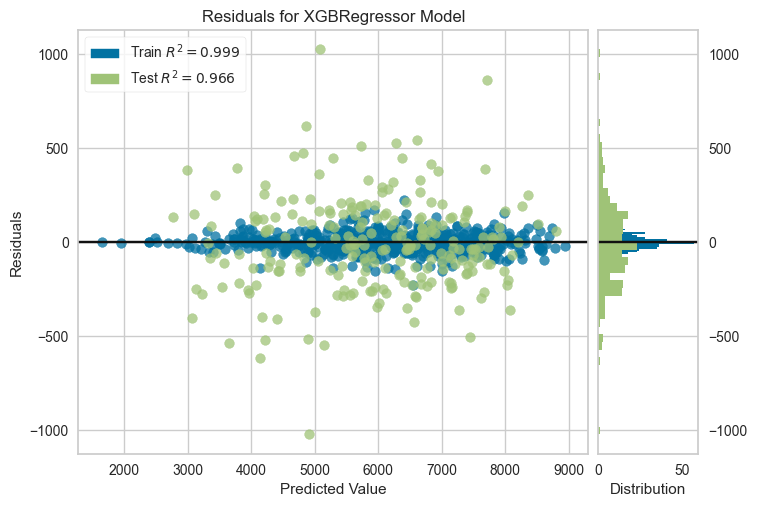

In [11]:
plot_model(tuned_model)

<h3>
<div style="background:yellow;color:black">RMSE automl XGB: 244.6365</div> 
</h3>

---

<b>Increasing the number of folds to 15</b>

In [42]:
dummy2 = rootdf.copy()
dummy2 = dummy2.drop(["seeds","fruitset","fruitmass"],axis=1)
dummy2.shape

(777, 14)

In [44]:
from pycaret.regression import * 
pycaret_automl = setup(data=dummy2, target = 'yield', session_id=88, fold=15)
#                                                              ^^^^

In [46]:
better_model = compare_models(sort="RMSE")

Initiated  . . . . . . . . . . . . . . . . . .           16:43:09
Status     . . . . . . . . . . . . . . . . . .   Fitting 15 Folds
Estimator  . . . . . . . . . . . . . . . . . .  Linear Regression

In [47]:
model_predictions = predict_model(better_model)

In [48]:
tuned_model2 = tune_model(better_model)
tuned_predictions2 = predict_model(better_model)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


<b>Seems that the xgboost overshooted this time resulting slight overfitting :: by looking at the RootMEANSqError</b>

In [51]:
# Displays the pipeline used 
final_model2 = finalize_model(tuned_model2)
final_model2

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['clonesize', 'honeybee', 'bumbles',
                                             'andrena', 'osmia',
                                             'MaxOfUpperTRange',
                                             'MinOfUpperTRange',
                                             'AverageOfUpperTRange',
                                             'MaxOfLowerTRange',
                                             'MinOfLowerTRange',
                                             'AverageOfLowerTRange',
                                             'RainingDays',
                                             'AverageRainingDays'],
                                    transformer=SimpleImputer())),
                ('categorical_imp...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=88, ...))])

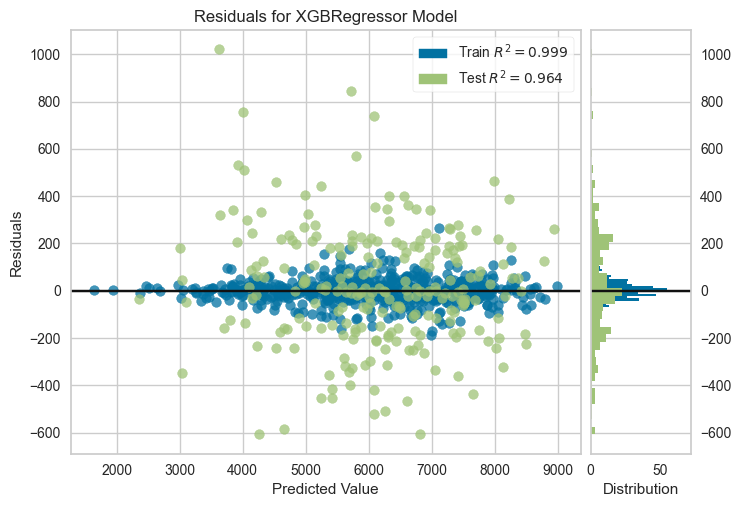

In [52]:
plot_model(tuned_model2)

#### <code style="background:yellow;color:black"> RMSE: 	248.6847 | XGboost Folds 15 AutoML</code>

---

<div class="alert alert-block alert-info">

## <b>Models Summary:</b> 🧾🧾🧾 


### <code style="background:yellow;color:black">XGBOOST (trained by me :) ::: RMSE ::: 261.18673647289495<br></code>

### <code style="background:yellow;color:black">XGBOOST (AutoML) sessionID:11 :::| 12 Folds | RMSE ::: 244.6365<br></code>

### <code style="background:yellow;color:black">XGBOOST (AutoML) sessionID:88 :::| 15 Folds | RMSE ::: 248.6847<br></code>


---

## `Explainable Ai`
_if you unfold the black box of our model's prediction sense ..._

Name: shap <br>
Version: 0.42.1

In [54]:
import shap

In [55]:
shap.initjs()

We'll be looking at both models 1. XGBoost (Trained by me) 2. XGBoost (AutoML) 244 RMSE

In [60]:
# Loading the model
automl_model = load_model('pycaret_automl_blueberry_yield_xgb12fold')

Transformation Pipeline and Model Successfully Loaded


In [58]:
X.shape

(777, 13)

In [61]:
# Creating a explainer object
explainer = shap.Explainer(automl_model.predict, X)

In [62]:
shap_values = explainer(X)

# Permutation explainer: 778it [10:54,  1.19it/s] 

Permutation explainer: 778it [10:54,  1.19it/s]                         


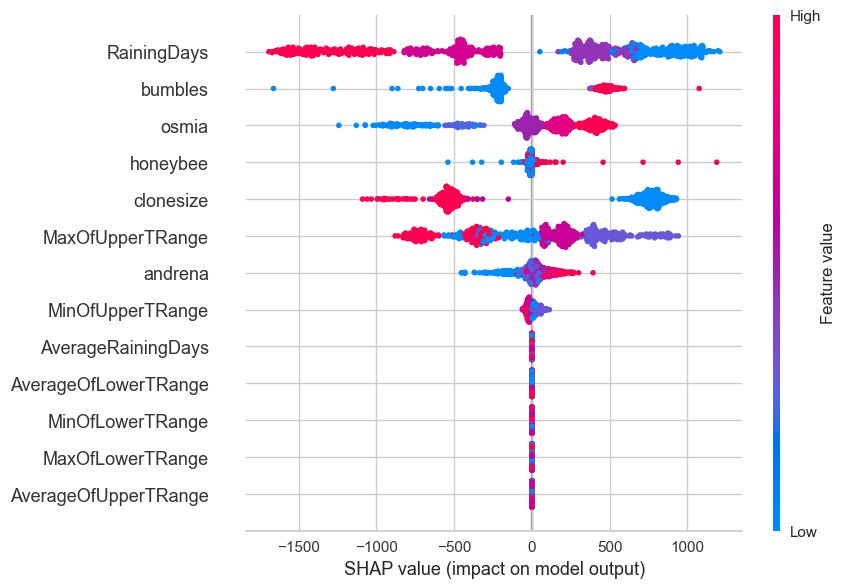

In [65]:
shap.plots.beeswarm(shap_values, max_display=20, order=shap_values.abs.max(0))

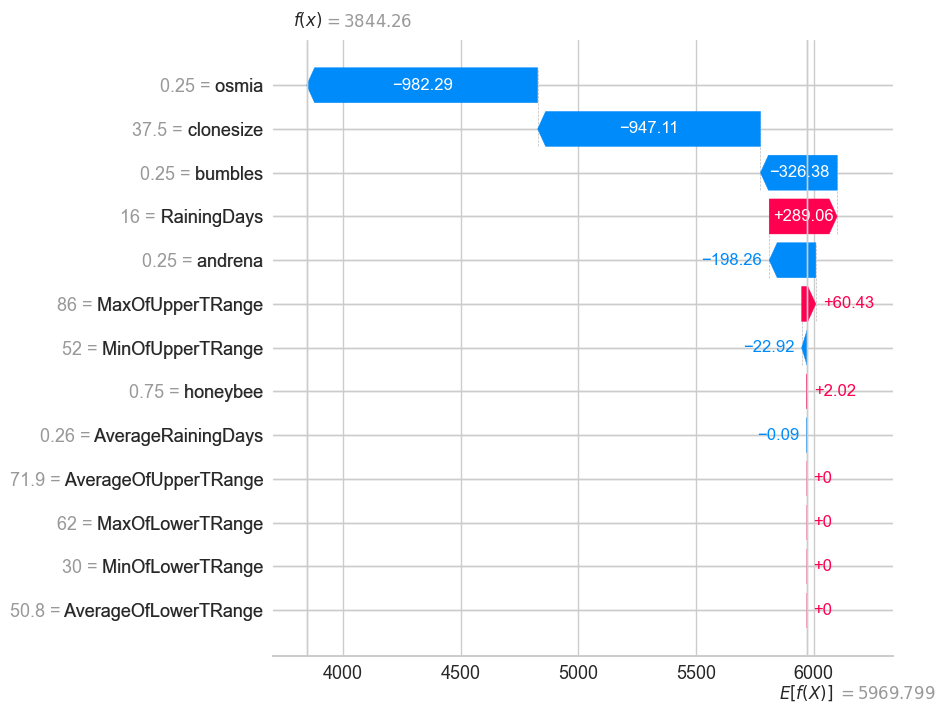

In [66]:
shap.plots.waterfall(shap_values[0], max_display=20)

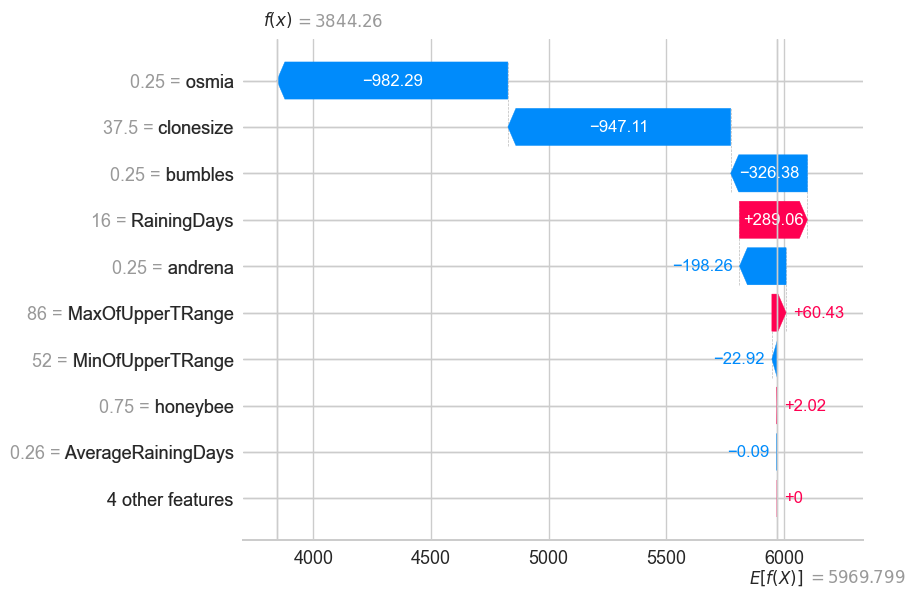

In [67]:
shap.plots.waterfall(shap_values[0])

In [69]:
# visualize the first prediction's explaination with default colors
shap.force_plot(shap_values,plot_cmap="DrDb")

In [72]:
# visualize the first prediction's explaination with default colors
shap.force_plot(shap_values[1])

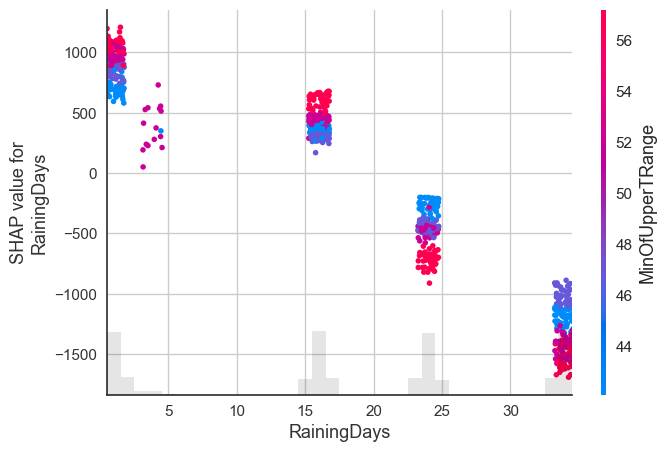

In [73]:
shap.plots.scatter(shap_values[:,"RainingDays"], color=shap_values)

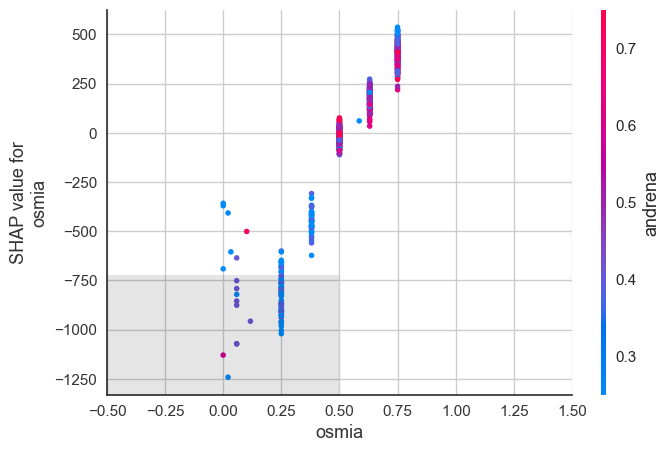

In [74]:
shap.plots.scatter(shap_values[:,"osmia"], color=shap_values)

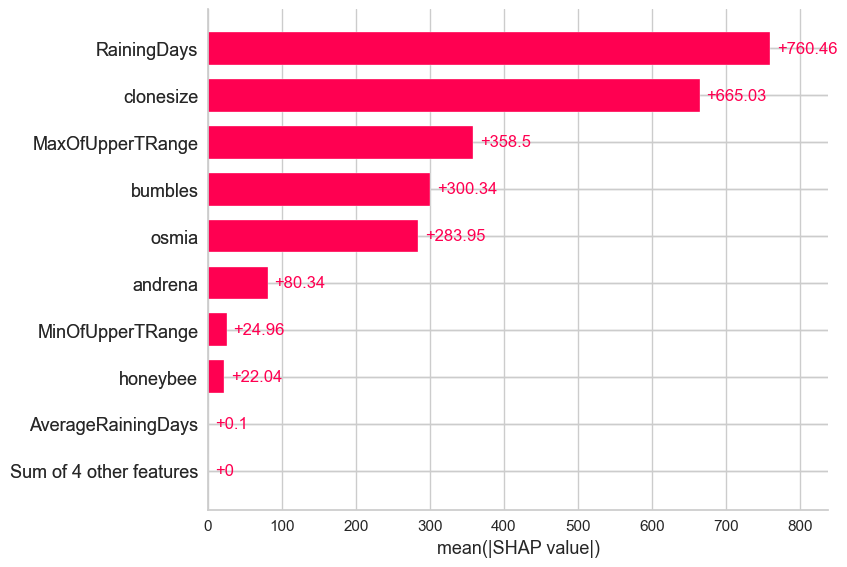

In [75]:
shap.plots.bar(shap_values)

Let's look at few plots for the XGBoost (Trained by me) model...

In [76]:
# Load the model
custom_xgb = pickle.load(open('xgboost_self_261.pkl','rb'))

In [77]:
# Creating a explainer object
explainer2 = shap.Explainer(custom_xgb.predict, X)

In [80]:
shap_values2 = explainer2(X)

# Permutation explainer: 778it [01:21,  8.21it/s]   

Permutation explainer: 778it [01:33,  7.60it/s]                         


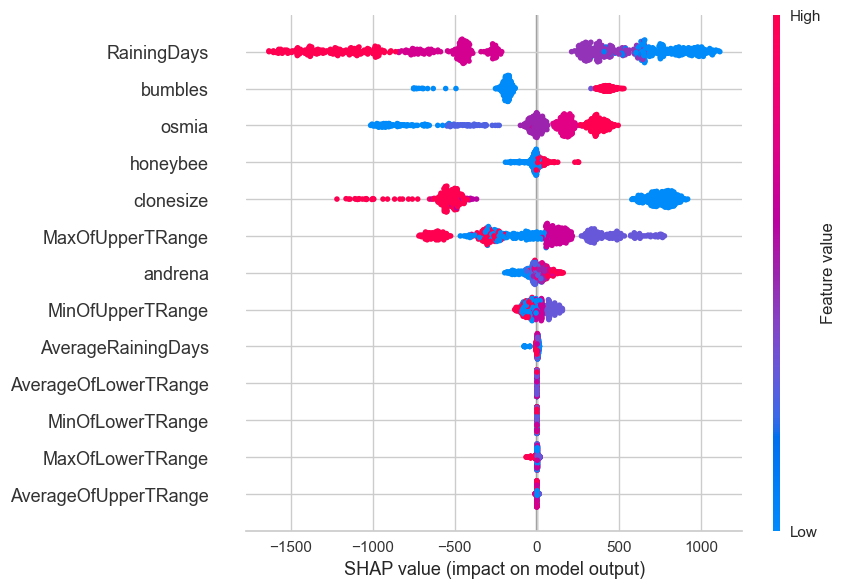

In [81]:
shap.plots.beeswarm(shap_values2, max_display=20, order=shap_values.abs.max(0))

In [82]:
# visualize the first prediction's explaination with default colors
shap.force_plot(shap_values2[1])

## User Interface Settings

yet to be deployed 